# Algorithm 1

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import itertools

# Implement the algorithm

In [2]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [3]:
class Algorithm:
    
    def __init__(self, N=20, M=10, t_1=10, epsilon=1, epsilon_0=1, beta=1, k=0.5, rho=3, d=1):
        # Set up the parameters for future runs
        self.d = d
        self.N = N
        self.M = M
        self.t_1 = t_1
        self.epsilon = epsilon
        self.epsilon_0 = epsilon_0
        self.beta = beta
        self.k = k
        self.rho = rho
        self.d = d
        self.N_tilde = N + M
        self.X_tilde = (N, M, k, beta)
        self.t_0 = 0
        self.c_0 = 1
        
        
    def f(self, param, y, scale, variable):
        #return scipy.stats.multivariate_normal.pdf(y, mean = param, cov = scale*np.diag(np.ones(self.d)))
        return sigmoid(np.dot(variable, param))

    def G_tilde(self, t_p, nu, w_tilde):
        i = np.argmax(w_tilde)
        return nu[i]

    def G(self, t_p, teta, w):
        return sum([teta[i] * w[i] for i in range(len(teta))]) / sum(w)
    
    def F_tilde(self, nu_bar, epsilon_p=0, X_bar=0, t_p=0):
        return np.array(list(itertools.product(np.linspace(-100*epsilon_p / self.K_(self.N_tilde),100*epsilon_p / self.K_(self.N_tilde), self.N_tilde**(1/self.d)), repeat=self.d))) + np.array(nu_bar)        


    def F(self, nu_bar, xi_p=0, X_bar=0, t_p=0):
        return np.array(list(itertools.product(np.linspace(-100*xi_p / self.K_(self.N), 100*xi_p / self.K_(self.N), self.N**(1/self.d)), repeat=self.d))) + np.array(nu_bar)        
    
    def t_(self, p, former_t_p):
        return former_t_p + max(int((self.k**(-2) - 1) * former_t_p) + 1, self.t_1)

    def epsilon_(self, p):
        # d ?
        return self.epsilon_0 * min(1, (p**(-1) * self.rho * np.log(p + 1))**(1 / (self.d + self.beta)))

    def c_(self, p):
        if p==0:
            return 1
        return min(((1 + self.k) / (2 * self.k))**p, p**((1 + self.epsilon) / 2))

    def K_(self, N):
        k = 1
        while k**self.d <= self.N:
            k += 1
        return k - 1
    
    
    def plot(self, time_interval, theta_star, scale, observation, theta, w, fig):
        # plot the real law
        x_density = np.linspace(-100,100,100) 
        y_density = 15 * scipy.stats.norm.pdf(x_density, loc=theta_star, scale=scale) 
        plt.clf()
        plt.plot(x_density, y_density) #plot real density function
        plt.scatter(theta, np.zeros(self.N), c="red")
        plt.scatter([observation], [15 * scipy.stats.norm.pdf(observation, loc=theta_star, scale=scale)], marker="*") # plot observation
        plt.bar(theta, w)
        fig.canvas.draw()
        plt.pause(time_interval)
        
    def plotd(self, time_interval, theta_star, scale, observation, theta, w, fig):
        # plot the real law
        plt.clf()
        for i, point in enumerate(theta):
            plt.scatter(point[0], point[1], c=(0.0, min(20*w[i], 1), 0.0))
        #plt.scatter([observation], [15 * scipy.stats.norm.pdf(observation, loc=theta_star, scale=scale)], marker="*") # plot observation
        fig.canvas.draw()
        plt.pause(time_interval)
        
    def bayes_update(self, distrib, support, f, scale, observation, variable):
        distrib = [distrib[i] * self.f(support[i], observation, scale, variable) for i in range(len(support))]
        sum_distrib = np.sum(distrib)
        distrib = [distrib[i] / sum_distrib for i in range(len(support))] # normalize
        
        return distrib



    
    def animate_pi_without_support(self, nb_iterations=10000, time_interval=0.001, theta_star=[0], scale=20):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.multivariate_normal(theta_star, scale*np.diag(np.ones(len(theta_star))), nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                q += 1
                xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                theta_hat = theta_bar
                theta = self.F(theta_hat, xi)
                w = np.ones(self.N)
                p += 1
                t_p = self.t_(p, t_p)
                

        ########## plotting
            if t % 10 == 0:
                self.plot(time_interval, theta_star, scale, observation = Y[t], theta=theta, w=w, fig=fig)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            
    def animate_pi(self, nb_iterations=10000, time_interval=0.001, theta_star=[0], scale=20):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.multivariate_normal(theta_star, scale*np.diag(np.ones(len(theta_star))), nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                nu_bar = self.G_tilde(t_p, nu, w_tilde)
                if np.linalg.norm(theta_bar - nu_bar) <= 2 * self.epsilon_(p):
                    q += 1
                    xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                    theta_hat = theta_bar
                else:
                    q = 1
                    xi = self.epsilon_(p)
                    theta_hat = nu_bar
                theta = self.F(theta_hat, xi)
                nu = self.F_tilde(nu_bar, self.epsilon_(p))
                w = np.ones(self.N)
                w_tilde = np.ones(self.N_tilde)
                p += 1
                t_p = self.t_(p, t_p)
        
    
        ########## plotting
            if t % 10 == 0:
                self.plot(time_interval, theta_star, scale, observation = Y[t], theta=theta, w=w, fig=fig)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            w_tilde = self.bayes_update(w_tilde, nu, self.f, scale, Y[t])


    
    def run_without_aux(self, nb_iterations, theta_star=[0], scale=20):
        #Initialize
        theta = np.random.uniform(-100, 100, self.N)
        nu = np.random.uniform(-100, 100, self.N + self.M)
        Y = np.random.multivariate_normal(theta_star, scale*np.diag(np.ones(len(theta_star))), nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        
        list_of_support = []
        list_of_distrib = []
        
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                theta_bar = self.G(t_p, theta, w)
                q += 1
                xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                theta_hat = theta_bar
                theta = self.F(theta_hat, xi)
                w = np.ones(self.N)
                p += 1
                t_p = self.t_(p, t_p)
                


            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            list_of_distrib.append(w)
            list_of_support.append(theta)
            
        
        return list_of_support, list_of_distrib
    
    def animate_d(self, nb_iterations, theta_star=[0], scale=20):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #Initialize
        theta = np.random.uniform(-100, 100, (self.N, self.d))
        nu = np.random.uniform(-100, 100, (self.N + self.M, self.d))
        Y = np.random.multivariate_normal(theta_star, scale*np.diag(np.ones(self.d)), nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        
        list_of_support = []
        list_of_distrib = []
        
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                nu_bar = self.G_tilde(t_p, nu, w_tilde)
                if np.linalg.norm(theta_bar - nu_bar) <= 2 * self.epsilon_(p):
                    print("OH")
                    q += 1
                    xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                    theta_hat = theta_bar
                else:
                    q = 1
                    xi = self.epsilon_(p)
                    theta_hat = nu_bar
                print("theta_bar = ")
                print(theta_bar)
                print("nu_bar =")
                print(nu_bar)
                theta = self.F(theta_hat, xi)
                nu = self.F_tilde(nu_bar, self.epsilon_(p))
                w = np.ones(self.N)
                w_tilde = np.ones(self.N_tilde)
                p += 1
                t_p = self.t_(p, t_p)
                
            
            ########## plotting
            if t % 1 == 0:
                self.plotd(0.005, theta_star, scale, observation = Y[t], theta=nu, w=w_tilde, fig=fig)

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t])
            w_tilde = self.bayes_update(w_tilde, nu, self.f, scale, Y[t])
            list_of_distrib.append(w)
            list_of_support.append(theta)
        
        return list_of_support, list_of_distrib

    def run(self, nb_iterations, theta_star=[0], scale=20):
        #Initialize
        theta = np.random.uniform(-100, 100, (self.N, self.d))
        nu = np.random.uniform(-100, 100, (self.N + self.M, self.d))
        X = np.random.randn(nb_iterations, self.d)
        probas = sigmoid(np.dot(X, theta_star))
        Y = np.array([np.random.binomial(1, proba) for proba in probas])
        #Y = np.random.multivariate_normal(theta_star, scale*np.diag(np.ones(self.d)), nb_iterations)
        w = (1/self.N) * np.ones(self.N)
        w_tilde = (1/self.N_tilde) * np.ones(self.N_tilde)
    
        t_p = self.t_1
        xi = 1
        p = 1
        q = 0
        
        list_of_support = []
        list_of_distrib = []
        
        for t in range(1, nb_iterations):
            if t == t_p + 1:
                # Perturbation
                print("PERTURBATION")
                theta_bar = self.G(t_p, theta, w)
                nu_bar = self.G_tilde(t_p, nu, w_tilde)
                if np.linalg.norm(theta_bar - nu_bar) <= 2 * self.epsilon_(p):
                    print("OH")
                    q += 1
                    xi = self.k * (self.c_(q) / self.c_(q - 1)) * xi
                    theta_hat = theta_bar
                else:
                    q = 1
                    xi = self.epsilon_(p)
                    theta_hat = nu_bar
                print("theta_bar = ")
                print(theta_bar)
                print("nu_bar =")
                print(nu_bar)
                theta = self.F(theta_hat, xi)
                nu = self.F_tilde(nu_bar, self.epsilon_(p))
                w = np.ones(self.N)
                w_tilde = np.ones(self.N_tilde)
                p += 1
                t_p = self.t_(p, t_p)
                
            

            ## Bayes updates
            w = self.bayes_update(w, theta, self.f, scale, Y[t], X[t])
            w_tilde = self.bayes_update(w_tilde, nu, self.f, scale, Y[t], X[t])
            list_of_distrib.append(w)
            list_of_support.append(theta)
        
        return list_of_support, list_of_distrib

    
    
    
        

# Animations

In [46]:
%matplotlib inline

In [47]:
test = Algorithm(d=2, N=300, M=100)

In [48]:
%matplotlib
test.animate_d(500, theta_star=[0, 0])

Using matplotlib backend: MacOSX
PERTURBATION
theta_bar = 
[-7.29066397 -4.74699654]
nu_bar =
[-1.43300603  0.56562251]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[-0.02216791 -1.11969873]
nu_bar =
[ 0.11498159 -0.98236511]


KeyboardInterrupt: 

# Convergence rates

## Wasserstein

In [4]:
def wassertein(alg, nb_tests, nb_iterations, theta_star=0, aux=True):
    df = pd.DataFrame(columns=["n", "distance"])

    for _ in range(nb_tests):
        if aux:
            list_of_support, list_of_distrib = alg.run(nb_iterations, theta_star)
        else:
            list_of_support, list_of_distrib = alg.run_without_aux(nb_iterations, theta_star)
            

        list_of_distances = [np.sqrt(np.sum([(list_of_support[index][i] - theta_star)**2 * list_of_distrib[index][i] for i in range(len(list_of_support[index]))])) for index in range(len(list_of_support))]
        new_df = pd.DataFrame(columns=["n", "distance"])
        new_df["distance"] = np.array(list_of_distances)
        new_df["n"] = np.array([i for i in range(len(list_of_distances))])
        df = pd.concat([df, new_df])

    return df
        

In [26]:
alg4 = Algorithm(d=5, N=6000, M=3000)

In [31]:
df = wassertein(alg4, 1, 2000,  theta_star=[0, 0, 0, 0, 0])

PERTURBATION
theta_bar = 
[ -1.03461986 -56.14112137   7.24957774 -98.14676451 -85.75746065]
nu_bar =
[-8.57265239 10.27543838  6.15212644  0.97158691  5.40750291]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
theta_bar = 
[ 1.42734761  0.27543838 -3.84787356  0.97158691 -4.59249709]
nu_bar =
[-4.57265239 -1.72456162 -5.84787356 -3.02841309  1.40750291]
PERTURBATION
theta_bar = 
[ 5.36147617 -1.72456162  4.15212644 -3.02841309  1.40750291]
nu_bar =
[-0.57265239  2.27543838 -1.84787356  0.97158691  5.40750291]
PERTURBATION
theta_bar = 
[-0.57265239  2.27543838 -1.84787356  0.97158691 -4.59249709]
nu_bar =
[ 3.42734761 -1.72456162  2.15212644 -3.02841309  1.40750291]


In [32]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


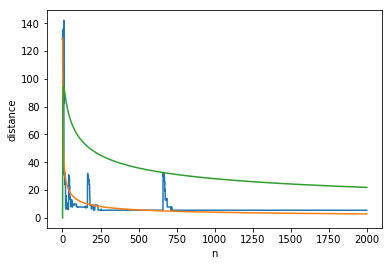

In [34]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [42]:
alg4 = Algorithm(d=5, N=3000, M=1000)

In [43]:
df = wassertein(alg4, 1, 1000,  theta_star=[0, 0, 0, 0, 0])

PERTURBATION
theta_bar = 
[ 25.18535637 -16.03467507 -57.36450153 -78.75351278  49.22258259]
nu_bar =
[ 66.30266101 -45.50865433 -90.80534987 -87.57405782  62.52976911]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[ 41.30266101 -20.50865433 -65.80534987 -62.57405782  87.52976911]
nu_bar =
[ 41.30266101 -20.50865433 -65.80534987 -62.57405782  87.52976911]
PERTURBATION
theta_bar = 
[ 16.30266101 -12.175321   -40.80534987 -37.57405782  62.52976911]
nu_bar =
[ 16.30266101 -20.50865433 -40.80534987 -37.57405782  62.52976911]
PERTURBATION
theta_bar = 
[ -8.69733899   4.49134567 -15.80534987 -12.57405782  37.52976911]
nu_bar =
[  3.80266101   4.49134567 -15.80534987 -12.57405782  37.52976911]


In [44]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


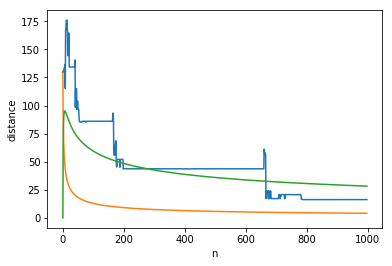

In [46]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [11]:
alg4 = Algorithm(d=2, N=300, M=100)

In [12]:
df = wassertein(alg4, 1, 1000,  theta_star=[0, 0])

PERTURBATION
theta_bar = 
[-4.48686342 -2.73300799]
nu_bar =
[-16.30696979   0.70737473]
PERTURBATION
OH
theta_bar = 
[-10.42491368  -1.00111338]
nu_bar =
[-10.42461685  -1.45980793]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[-4.54256074 -0.45734579]
nu_bar =
[-4.54226391 -0.53101536]
PERTURBATION
OH
theta_bar = 
[-0.13079755 -0.37211235]
nu_bar =
[ 0.10169894 -0.22141783]


In [13]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


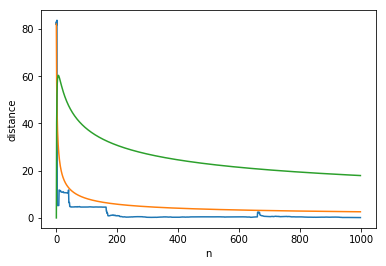

In [15]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [21]:
alg4 = Algorithm(d=3, N=1000, M=500)

In [22]:
df = wassertein(alg4, 1, 1000,  theta_star=[0, 0, 0])

PERTURBATION
theta_bar = 
[-2.17256166 -0.26794238 -5.40524295]
nu_bar =
[  9.93840282 -17.73730066   4.8825926 ]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[ 2.3033527  -7.73730084  3.72186507]
nu_bar =
[ 1.93840282 -7.73730066  2.8825926 ]
PERTURBATION
theta_bar = 
[-0.1966473  -0.23730084 -1.26188587]
nu_bar =
[-0.06159718  0.26269934  0.8825926 ]
PERTURBATION
OH
theta_bar = 
[-0.06159718  0.26269934  0.8825926 ]
nu_bar =
[-0.06159718  0.26269934  0.8825926 ]


In [23]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


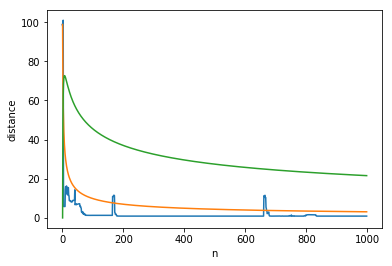

In [25]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [29]:
alg4 = Algorithm(d=2, N=300, M=100)

In [30]:
df = wassertein(alg4, 1, 1000,  theta_star=[0, 0])

PERTURBATION
theta_bar = 
[2.13333141 6.59242517]
nu_bar =
[ 3.06196537 -5.64435738]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[-0.47172879 -0.40486812]
nu_bar =
[-0.34360739 -0.38119948]
PERTURBATION
OH
theta_bar = 
[0.24679887 0.65550901]
nu_bar =
[-0.03400987  0.54759309]
PERTURBATION
OH
theta_bar = 
[-0.26918943  0.12345738]
nu_bar =
[-0.34360739  0.23799556]


In [31]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


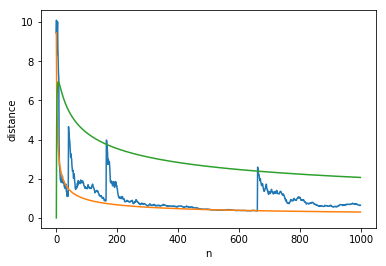

In [33]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


In [24]:
alg4 = Algorithm(d=3, N=1000, M=500)

In [25]:
df = wassertein(alg4, 1, 1000,  theta_star=[0, 0, 0])

PERTURBATION
theta_bar = 
[-4.68284984  1.48466512 -5.28230479]
nu_bar =
[-7.17757801 -4.79281839 -2.02234608]


/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PERTURBATION
OH
theta_bar = 
[1.8020323  0.50423737 0.4056679 ]
nu_bar =
[ 0.82242199  1.20718161 -0.02234608]
PERTURBATION
OH
theta_bar = 
[-0.69794073  0.50423633  0.40566739]
nu_bar =
[-1.17757801 -0.79281839 -0.02234608]
PERTURBATION
OH
theta_bar = 
[0.05553289 0.50423633 0.40566739]
nu_bar =
[ 0.82242199 -0.79281839 -0.02234608]


In [26]:
df_sqrt = pd.DataFrame(columns=["n", "distance"])
df_sqrt["n"] = np.unique(df["n"])
df_sqrt["distance"] = [df["distance"].iloc[0]/np.sqrt(i) for i in range(len(df_sqrt))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df_log = pd.DataFrame(columns=["n", "distance"])
df_log["n"] = np.unique(df["n"])
df_log["distance"] = [df["distance"].iloc[0] * np.log(i)**((1 + alg4.epsilon)/2) / np.sqrt(i) for i in range(len(df_log))]

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


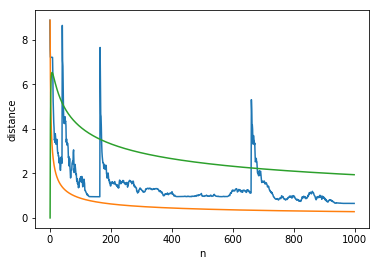

In [28]:
sns.lineplot(x="n", y="distance", data=df)
sns.lineplot(x="n", y="distance", data=df_sqrt)
sns.lineplot(x="n", y="distance", data=df_log)


## Convergence presque-sûr

In [33]:
def check_concentration(alg, speed, N_samples_for_estimation, n, step=30, number_of_trials_per_step=10, theta_star=0, aux=True):
    df = pd.DataFrame(columns=["n", "proba"])
    for trial in range(number_of_trials_per_step):
        if aux:
            list_of_support, list_of_distrib = alg.run(n, theta_star)
        else:
            list_of_support, list_of_distrib = alg.run_without_aux(n, theta_star)
        for i in range(1, n, step): # begins at 3 because we remove 2 lines
            support = list_of_support[i]
            distrib = list_of_distrib[i]
            count_inside_ball = 0
            for k in range(N_samples_for_estimation):
                count_inside_ball += np.linalg.norm(np.random.choice(support, p=distrib) - theta_star)< 1 / speed(i)
            df2 = pd.DataFrame([[i, count_inside_ball / N_samples_for_estimation]],columns=['n', 'proba'])
            df = pd.concat([df,df2])
    sns.barplot(x='n', y="proba", data = df)

In [34]:
alg2 = Algorithm()

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


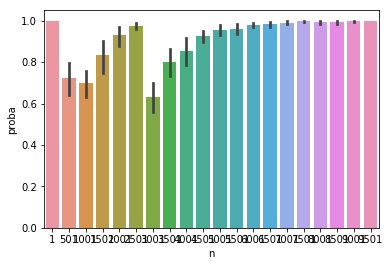

In [42]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*np.log(x), 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


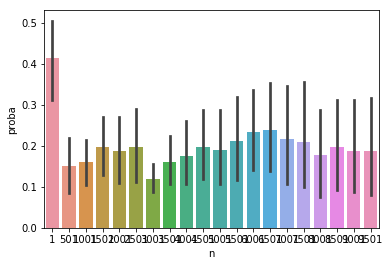

In [43]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*np.sqrt(x), 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);

/Users/anne/anaconda/envs/modal/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


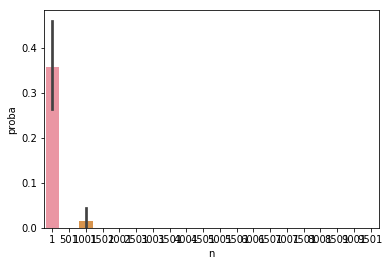

In [44]:
step = 500
n = 10000
N_samples_for_estimation = 30
number_of_trials_per_step = 20
check_concentration(alg2, lambda x:0.1*x, 1000, n=n, step=step, number_of_trials_per_step=number_of_trials_per_step);